pygame 2.1.2 (SDL 2.0.18, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
0
0
100
200
300
300
400
500
600
600
e: 3
nii: 5
ln: 2
e/(nii - ln): 1.0
700
e: 4
nii: 5
ln: 0
e/(nii - ln): 0.8
800
e: 4
nii: 5
ln: 0
e/(nii - ln): 0.8
900
900
e: 4
nii: 5
ln: 0
e/(nii - ln): 0.8
1000
e: 4
nii: 5
ln: 0
e/(nii - ln): 0.8
1100
e: 4
nii: 5
ln: 0
e/(nii - ln): 0.8
1200
1200
e: 4
nii: 5
ln: 0
e/(nii - ln): 0.8
1300
e: 5
nii: 6
ln: 1
e/(nii - ln): 1.0
1400
e: 5
nii: 6
ln: 1
e/(nii - ln): 1.0
1500
1500
e: 5
nii: 8
ln: 3
e/(nii - ln): 1.0
1600
e: 5
nii: 9
ln: 4
e/(nii - ln): 1.0
1700
e: 5
nii: 10
ln: 5
e/(nii - ln): 1.0
1800
1800
e: 5
nii: 11
ln: 6
e/(nii - ln): 1.0
1900
e: 6
nii: 12
ln: 6
e/(nii - ln): 1.0
2000
e: 10
nii: 13
ln: 5
e/(nii - ln): 1.25
2100
2100
e: 11
nii: 15
ln: 6
e/(nii - ln): 1.222
2200
e: 12
nii: 15
ln: 5
e/(nii - ln): 1.2
2300
e: 15
nii: 18
ln: 7
e/(nii - ln): 1.364
2400
2400
e: 16
nii: 18
ln: 5
e/(nii - ln): 1.231
2500
e: 16
nii: 21
ln: 7
e/(nii 

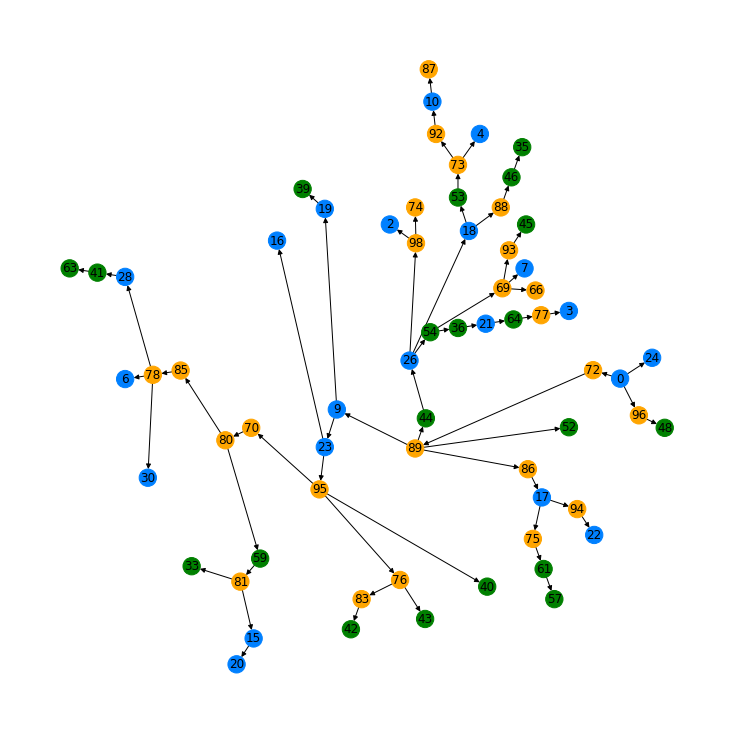

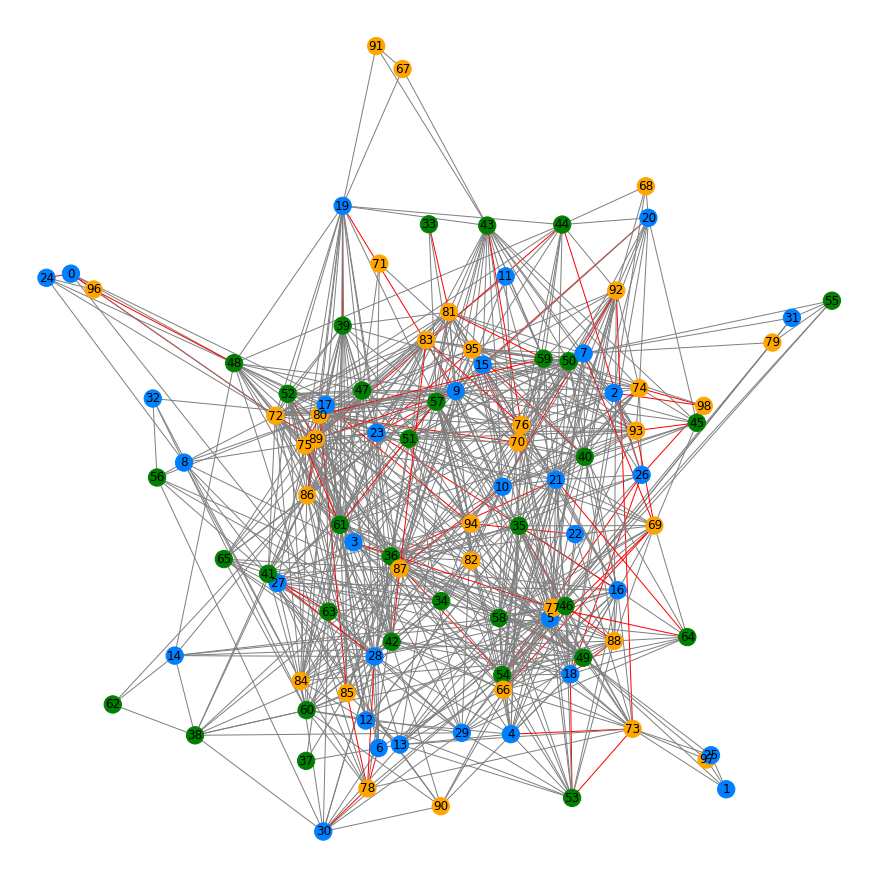

e: 64
nii: 65
ln: 0
e/(nii - ln): 0.985
Vulnerabilities for infected nodes:
number of high vulnerability nodes: 24
number of medium vulnerability nodes: 21
number of low vulnerability nodes: 20


Vulnerabilities for all nodes in model: 
number of high vulnerability nodes: 33
number of medium vulnerability nodes: 33
number of low vulnerability nodes: 33


R0 = 0.98
High Vulnerability Proximity Clustering & Propagation Degree:
clustering: 0.2600806451612903 | degree: 0
clustering: 0.4505928853754941 | degree: 0
clustering: 1.0 | degree: -1
clustering: 0.40942028985507245 | degree: 1
clustering: 0.4782608695652174 | degree: 3
clustering: 0.2909090909090909 | degree: 3
clustering: 0.34210526315789475 | degree: 1
clustering: 0.42592592592592593 | degree: 1
clustering: 0.391812865497076 | degree: 2
clustering: 0.9 | degree: -1
clustering: 0.2761904761904762 | degree: 1
clustering: 0.4417989417989418 | degree: 1
clustering: 0.6666666666666666 | degree: -1
clustering: 0.45751633986928103 | deg

error: video system not initialized

In [1]:
import pygame
import random
import networkx as nx
import matplotlib.pyplot as plt
from enum import Enum
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

# Propagation/Cascading Network
G=nx.DiGraph(name='G')
# Trajectory Network | Tracks nodes that came within close proximity at one point
P=nx.Graph(name='P')
random.seed(534543642221)
# random.seed(534543642222)


# constants
WIDTH, HEIGHT = 1200,900
WIN = pygame.display.set_mode([WIDTH, HEIGHT])
WHITE = (255,255,255)
FPS = 100
NODES = 99
NODE_SIZE = 20
INITIAL_INFECTIONS = 1
RECOVERY_TIME = 750
IMMUNITY = 0.95
TS = 300


class Vulnerability(Enum):
#     LOW = [(10,13),(0.97,1), (500,100), (0,255,0)]
#     MEDIUM = [(14,17),(0.93,0.97), (750,150), (0,128,255)]
#     HIGH = [(18,21),(0.9,0.93), (1000,300),(255,128,0)]
    LOW = [(10,13),(0.97,1), (700,100), (0,255,0)]
    MEDIUM = [(14,17),(0.93,0.97), (950,150), (0,128,255)]
    HIGH = [(18,21),(0.9,0.93), (1200,300),(255,128,0)]
    
    
class State(Enum):
    SUSCEPTIBLE = 1
    INFECTIOUS = 2
    RECOVERED = 3

def get_vulnerability(i):
#     p = random.normalvariate(0.5, 0.125)
    p = random.random()
#     if(p<0.333333):
#         return Vulnerability.LOW
#     elif(p<0.666666):
#         return Vulnerability.MEDIUM
#     else:
#         return Vulnerability.HIGH
    if(i<33):
        return Vulnerability.MEDIUM
    elif(i<66):
        return Vulnerability.LOW
    else:
        return Vulnerability.HIGH


class Node(pygame.sprite.Sprite):
    def __init__(self, pos_x,pos_y,id, home):
        super().__init__()
        self.id = id
        self.vulnerability = get_vulnerability(self.id)
        self.width = random.randint(self.vulnerability.value[0][0],self.vulnerability.value[0][1])
        self.image = pygame.Surface([self.width, self.width])
        self.image.fill(self.vulnerability.value[3])
        # self.image.fill((0,0,255))
        self.rect = self.image.get_rect()
        self.rect.center = [pos_x, pos_y]
        self.home = home
#         self.destination = (random.randint(0,WIDTH),random.randint(0,HEIGHT))
        self.destination = (random.randint(self.home[0],(self.home[0]+100)),random.randint(self.home[1],(self.home[1]+100)))
        self.reached_x = False
        self.reached_y = False
        self.state = State.SUSCEPTIBLE
        self.is_home = True
        self.public_dest = -1
#         self.infected = False
#         self.recovered = False
        self.days_infected = -1
        self.immunity = random.uniform(self.vulnerability.value[1][0],self.vulnerability.value[1][1])
        self.recovery_time = random.randint(self.vulnerability.value[2][0]-self.vulnerability.value[2][1],self.vulnerability.value[2][0]+self.vulnerability.value[2][1])

    
    def infect(self, received_from):
        if self.state == State.SUSCEPTIBLE:
            self.state = State.INFECTIOUS
#             self.infected = True
            self.image.fill((255,0,0))
            
            if received_from == None:
                G.add_node(self.id, data = self)
                
            else:
                if not G.has_node(received_from.id):
                    G.add_node(received_from.id, data = received_from)
                if not G.has_node(self.id):
                    G.add_node(self.id, data = self)
                G.add_edge(received_from.id,self.id)
                P[received_from.id][self.id]['color'] = 'red'
            
    
    def recover(self):
        if self.state == State.INFECTIOUS:
            self.state == State.RECOVERED
#             self.infected = False
#             self.recovered = True
            self.image.fill((0,0,0))
            self.immunity = 2

        

        
        
pygame.init()

all_nodes = []


# CREATE SURFACE

homes = []
pubsurfs = [(300,225),(700,225),(300,475),(700,475)]

home = pygame.Surface([100,100])
home.fill((140, 145, 140))

public = pygame.Surface([200,200])
public.fill((211, 222, 118))


y=60
x=60

while x <= 1040:
    homes.append((x,60))
    homes.append((x,740))
    x+=163
while y < 610:
    y+=110
    homes.append((60,y))
    homes.append((1040,y))
    
def main():
    
    # variable initialization
    t = 0
    nodes = []
    node_group = pygame.sprite.Group()
    infected_nodes = []
    recovered_nodes = []
    i_nodes = []
    r0 = []
    infections_ts = []
    
#     CREATE INITIAL NODES
    for i in range(NODES):
#         h = random.randint(0,len(homes)-1)
        h = i % len(homes)
        h = homes[h]
        obj = Node(random.randint(h[0],(h[0]+100)),random.randint(h[1],(h[1]+100)),i, h)
#         obj.home = h
        if i < INITIAL_INFECTIONS:
            obj.infect(None)
            infected_nodes.append(obj)
            i_nodes.append(obj.id)
        node_group.add(obj)
        nodes.append(obj)

    
#     ARANGE WHICH NODES ARE ASSIGNED TO WHICH HOME
#     
# 
# 
    
    running = True
    clock = pygame.time.Clock()
    all_nodes = nodes
    
    
# TIMESTAMP DATA TRACKING
    
    def save_g(time):
        color_map = []
        for node in G:       
            node = G.nodes[node]['data']
            if node.recovered:
                color_map.append('green')
            else:
                color_map.append('red')
        pos = graphviz_layout(G, prog="twopi")
        plt.figure(figsize=(10,10))
        print(time)
        plt.title('t = '+str(t)+' | R0 = ' + str(round(get_R0(),3)))
        nx.draw(G,pos, node_color=color_map, with_labels = True)
#         nx.draw(G, node_color=color_map, with_labels = True)
#         nx.draw(G,pos, node_color=color_map)
        plt.savefig('images/propagation'+str(int(time))+'.png')
        plt.clf()
        
    def r0_graph():
        print(r0)
        ts = [x for x, y in r0]
        data = [y for x, y in r0]
        (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
        plt.plot(ts,data)
        plt.title("R0 values")
        ax2.set_xlabel('Time Stamp')
        ax2.set_ylabel('R0')
        plt.savefig("images/r0.png")
        plt.show()
    def infections_graph():
        print(infections_ts)
        ts = [x for x, y in infections_ts]
        data = [y for x, y in infections_ts]
        (ax1, ax2) = plt.subplots(ncols=1, figsize=(10, 10))
        plt.plot(ts,data)
        plt.title("Infections Over Time")
        ax2.set_xlabel('Time Stamp')
        ax2.set_ylabel('Infections')
        plt.savefig("images/infections.png")
        plt.show()
    
    while running:
        
#         STOP RUNNING IF THERE IS NO MORE INFECTED NODES

        if len(infected_nodes) == 0:
#             save_g(t)
#             r0_graph()
#             infections_graph()
            running = False
            pygame.quit()
            post_quit()
            exit()
            
        if (t % TS) == 0:
#             save_g(t)
            print(t)
            
        if (t % 100) == 0:
            print(t)
            r0.append((t,round(get_R0(),3)))
            infections_ts.append((t,len(infected_nodes)))
        t+=1
        
        # event loop
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                pygame.quit()
                post_quit()
                exit()
        
        def proximity_add_edge(n1,n2):
            if n1.id==n2.id:
                return
            if not P.has_edge(n1.id,n2.id):
                if not P.has_node(n1.id):
                    P.add_node(n1.id, data = n1)
                if not P.has_node(n2.id):
                    P.add_node(n2.id, data = n2)
                P.add_edge(n1.id,n2.id)
                P[n1.id][n2.id]['weight'] = 1
                P[n1.id][n2.id]['color'] = 'grey'
                
            elif P.has_edge(n1.id,n2.id):
                P[n1.id][n2.id]['weight'] += 1
                


        
        # collisions and infections
        to_infect = []
        
        for node in nodes:
            collisions = pygame.sprite.spritecollide(node, node_group, False)
            if len(collisions) > 1:
                for i in range(len(collisions)):
                    proximity_add_edge(node,collisions[i])
                    # add edge to proximity graph
        
        for infected in infected_nodes:
            collisions = pygame.sprite.spritecollide(infected, node_group, False)
            if len(collisions) > 1:
                for i in range(len(collisions)):
                    # add edge to proximity graph
                    if (collisions[i].state == State.SUSCEPTIBLE) and random.random() >= collisions[i].immunity:
                        to_infect.append((infected,collisions[i]))
        

                    


        for n in to_infect:
            n[1].infect(n[0])
            infected_nodes.append(n[1])
            i_nodes.append(n[1].id)
        # print(i_nodes)

        # node recovery
        for n in infected_nodes:
            if n.days_infected >= n.recovery_time:
                n.recover()
                infected_nodes.remove(n)
                recovered_nodes.append(n)
            else:
                n.days_infected += 1

        # graphics
        WIN.fill(WHITE)
        
#         INITIAL HOME PLACEMENT
        y=60
        x=60
        while x <= 1040:

            WIN.blit(home, (x,60))
            WIN.blit(home, (x,740))
            x+=163
        while y < 610:
            y+=110
            WIN.blit(home, (60,y))
            WIN.blit(home, (1040,y))
        
        for i in range(len(pubsurfs)):
            WIN.blit(public,pubsurfs[i])

        
        for n in node_group:
            if n.rect.center[0] != n.destination[0] and n.reached_x==False:
                n.rect.right += (n.destination[0]-n.rect.center[0])/abs(n.destination[0]-n.rect.center[0])
            else:
                n.reached_x = True
            if n.rect.center[1] != n.destination[1] and n.reached_y==False:
                n.rect.bottom += (n.destination[1]-n.rect.center[1])/abs(n.destination[1]-n.rect.center[1])
            else:
                n.reached_y = True
            if n.reached_x and n.reached_y:
#                 n.destination = (random.randint(0,WIDTH),random.randint(0,HEIGHT))
                l = 100
                if n.is_home:
                    p = random.randint(0,1000)
                    if p > 985:
                        n.is_home = False
                        l = 200
                        n.public_dest = random.randint(0,3)
                        h = pubsurfs[n.public_dest]
                    else:
                        h = n.home
                        l = 100
                else:
                    p = random.randint(0,1000)
                    if p > 970:
                        n.is_home = True
                        l = 100
                        h = n.home
                    else:
                        l=200
                        h = pubsurfs[n.public_dest]
                n.destination = (random.randint(h[0],(h[0]+l)),random.randint(h[1],(h[1]+l)))
                n.reached_x = n.destination[0] == n.rect.center[0]
                n.reached_y = n.destination[1] == n.rect.center[1]

        node_group.draw(WIN)
        pygame.display.flip()
        clock.tick(FPS)

def post_quit():
    draw_G()
    draw_P()
    r0 = get_R0()
    print_vulnerabilities(G)
    print_vulnerabilities(P)
    print('R0 = ' + str(round(r0,2)))
    cd = clustering_degree()
    print('Average Degree for High Vulnerability: ' + str(avg_degree(cd['h'])))
    print('Average Clustering for High Vulnerability: ' + str(avg_clustering(cd['h'])))
    print('Average Degree for Medium Vulnerability: ' + str(avg_degree(cd['m'])))
    print('Average Clustering for Medium Vulnerability: ' + str(avg_clustering(cd['m'])))
    print('Average Degree for Low Vulnerability: ' + str(avg_degree(cd['l'])))
    print('Average Clustering for Low Vulnerability: ' + str(avg_clustering(cd['l'])))
    print(G.number_of_nodes())
    print(G.number_of_edges())
    print(P.number_of_nodes())
    print(P.number_of_edges())
    print("Global Clustering for gcer1: "+str(round(nx.average_clustering(G),3)))
    print("Global Clustering for gcer1: "+str(round(nx.average_clustering(P),3)))
    print((G.number_of_edges())/G.number_of_nodes())
    print((2*P.number_of_edges())/99)


def print_vulnerabilities(G):
    h = 0
    m = 0
    l=0

    for n in G:
#         print(G.nodes[n]['data'].vulnerability)
        if G.nodes[n]['data'].vulnerability == Vulnerability.HIGH:
            h += 1
        elif G.nodes[n]['data'].vulnerability == Vulnerability.MEDIUM:
            m+= 1
        else:
            l += 1
    g_name = ' for infected nodes:'
    if G.name == 'P':
        g_name = ' for all nodes in model: '
    print('Vulnerabilities' + g_name)
    print('number of high vulnerability nodes: ' + str(h))
    print('number of medium vulnerability nodes: ' + str(m))
    print('number of low vulnerability nodes: ' + str(l))
    print('\n')
    

def avg_clustering(a):
    i = 0
    c = 0
    for n in a:
        n = n[0]
        i += 1
        c += n
    if i == 0:
        return -1
    return round(c/i,4)

def avg_degree(a):
    i = 0
    d = 0
    for n in a:
        n = n[1]
        if n < 0:
            continue
        i += 1
        d += n
    if i == 0:
        return -1
    return round(d/i,4)


def draw_G():
    color_map = []
    for node in G:       
        node = G.nodes[node]['data']
        if node.vulnerability == Vulnerability.HIGH:
            color_map.append('orange')
        elif node.vulnerability == Vulnerability.MEDIUM:
            color_map.append('#0080FF')
        else:
            color_map.append('green')
    pos = graphviz_layout(G, prog="twopi")
    plt.figure(figsize=(10,10))
    nx.draw(G,pos, node_color=color_map, with_labels = True)
    # nx.draw(G, node_color=color_map, with_labels = True)
    plt.savefig("images/propagation.png")
    plt.show()

def draw_P():
    color_map = []
    for node in P:       
        node = P.nodes[node]['data']
        if node.vulnerability == Vulnerability.HIGH:
            color_map.append('orange')
        elif node.vulnerability == Vulnerability.MEDIUM:
            color_map.append('#0080FF')
        else:
            color_map.append('green')
    colors = [P[u][v]['color'] for u,v in P.edges()]
    plt.figure(figsize=(12,12))
    nx.draw(P, node_color=color_map, edge_color=colors, with_labels = True)
    plt.savefig("images/proximity.png")
    plt.show()

# def get_R0():
#     ln = 0 
#     e = 0
#     nii = 0
#     for n in G.nodes:
#         if G.out_degree(n) == 0 and G.nodes[n]['data'].infected :
#             nii+=1
#             ln+=1
#         elif G.nodes[n]['data'].infected:
#             nii+=1
#             e += G.out_degree(n)
#     if ((nii - ln)) ==0:
#         return 0
# #     return G.number_of_edges()/(G.number_of_nodes())
# #     return G.number_of_edges()/(G.number_of_nodes() - ln)
#     print('e: ' + str(e))
#     print('nii: ' + str(nii))
#     print('ln: ' + str(ln))
#     print('e/(nii - ln): ' +str(round(e/(nii - ln),3)))
#     return e/(nii - ln)

def get_R0():
    ln = 0 
    e = 0
    nii = 0
    for n in G.nodes:
        if float(G.nodes[n]['data'].days_infected/G.nodes[n]['data'].recovery_time)<0.5 and G.nodes[n]['data'].state == State.INFECTIOUS:
            nii+=1
            ln+=1
#         else:
        elif G.nodes[n]['data'].state == State.INFECTIOUS:
            nii+=1
            e += G.out_degree(n)
    if ((nii - ln)) ==0:
        return 0
#     return G.number_of_edges()/(G.number_of_nodes())
#     return G.number_of_edges()/(G.number_of_nodes() - ln)
    print('e: ' + str(e))
    print('nii: ' + str(nii))
    print('ln: ' + str(ln))
    print('e/(nii - ln): ' +str(round(e/(nii - ln),3)))
    return e/(nii - ln)

def clustering_degree():
    h = []
    m = []
    l = []
    cluster = nx.clustering(P)
#     print(cluster)
    for node in P:       
        node = P.nodes[node]['data']
        c = cluster[node.id]
        d = -1
        try:
            d = G.out_degree(node.id)
        except:
            d = -1

        if node.vulnerability == Vulnerability.HIGH:
            h.append((c,d))
        elif node.vulnerability == Vulnerability.MEDIUM:
            m.append((c,d))
        else:
            l.append((c,d))
    print('High Vulnerability Proximity Clustering & Propagation Degree:')
    for n in h:
        print('clustering: ' + str(n[0]) + ' | degree: ' + str(n[1]))
    print('Medium Vulnerability Proximity Clustering & Propagation Degree:')
    for n in m:
        print('clustering: ' + str(n[0]) + ' | degree: ' + str(n[1]))
    print('Low Vulnerability Proximity Clustering & Propagation Degree:')
    for n in l:
        print('clustering: ' + str(n[0]) + ' | degree: ' + str(n[1]))
    return {'h':h,'m':m,'l':l}

# if __name__ == "__main__":
#     main()
main()